# NYC Airbnb Dataset Price Prediction

### Description
This classification task is based on the Kaggle dataset: <a href=https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data >New York City Airbnb Open Data</a>. The dataset is under public domain license (v10.0).


### Purpose
The purpose of this notebook is to showcase various data processing and estimating techniques based on the NYC Airbnb dataset. For the target variable, daily Airbnb rental prices were selected. Our goal is to create a model that predicts the target feature reasonably well based on the 9 independent variables:
 
1. Host Id
2. Host name
3. Latitude
4. Longitude
5. Minimum nights
6. Number of reviews
7. Reviews per month
8. Calculated host listing count
9. Availability 

---

## Table of contents
1. [Dataset](#dataset)
2. [Exploratory Data Analysis](#eda)
3. [Refining the data](#data_ref)
4. [Simple Regression](#slr)
5. [DNN Regression](#dnn)
6. [XGBoost](#xgb)
7. [Model Comparison](#comparison)

<a id='dataset'></a>

## 1. Dataset

In [5]:
import zipfile
import os 
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import tensorflow as tf
from matplotlib import transforms
from scipy.stats import gaussian_kde
from scipy import stats
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
%matplotlib inline  

In [6]:
df = pd.read_csv("data/AB_NYC_2019.csv",index_col=0)

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
host_id,48895.0,6.762001e+07,7.861097e+07,2438.00000,7.822033e+06,3.079382e+07,1.074344e+08,2.743213e+08
latitude,48895.0,4.072895e+01,5.453008e-02,40.49979,4.069010e+01,4.072307e+01,4.076311e+01,4.091306e+01
longitude,48895.0,-7.395217e+01,4.615674e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48895.0,1.527207e+02,2.401542e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48895.0,7.029962e+00,2.051055e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48895.0,2.327447e+01,4.455058e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38843.0,1.373221e+00,1.680442e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
calculated_host_listings_count,48895.0,7.143982e+00,3.295252e+01,1.00000,1.000000e+00,1.000000e+00,2.000000e+00,3.270000e+02
availability_365,48895.0,1.127813e+02,1.316223e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


<a id='eda'></a>

## 2. Exploratory Data Analysis

In [8]:
eda_df = df.copy()

for c in ["price","minimum_nights","number_of_reviews"]:
    eda_df = eda_df[(np.abs(stats.zscore(df[c])) < 2)]

C:\Users\nemet\AppData\Local\Temp\ipykernel_9152\64900089.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  eda_df = eda_df[(np.abs(stats.zscore(df[c])) < 2)]


### 2.1. Distribution of features by neigborhoud groups

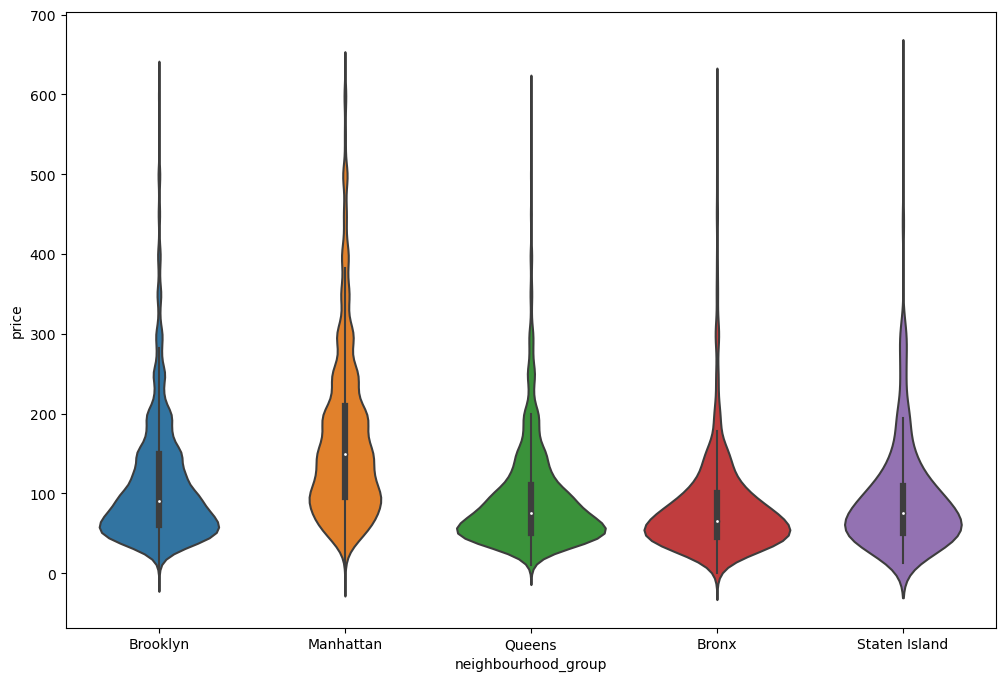

In [9]:
plt.figure(figsize=(12,8))
ax = sns.violinplot(x="neighbourhood_group", y="price", data=eda_df)
plt.show()

### 2.2. Plotting latitude and longitude on NYC map

<Figure size 640x480 with 0 Axes>

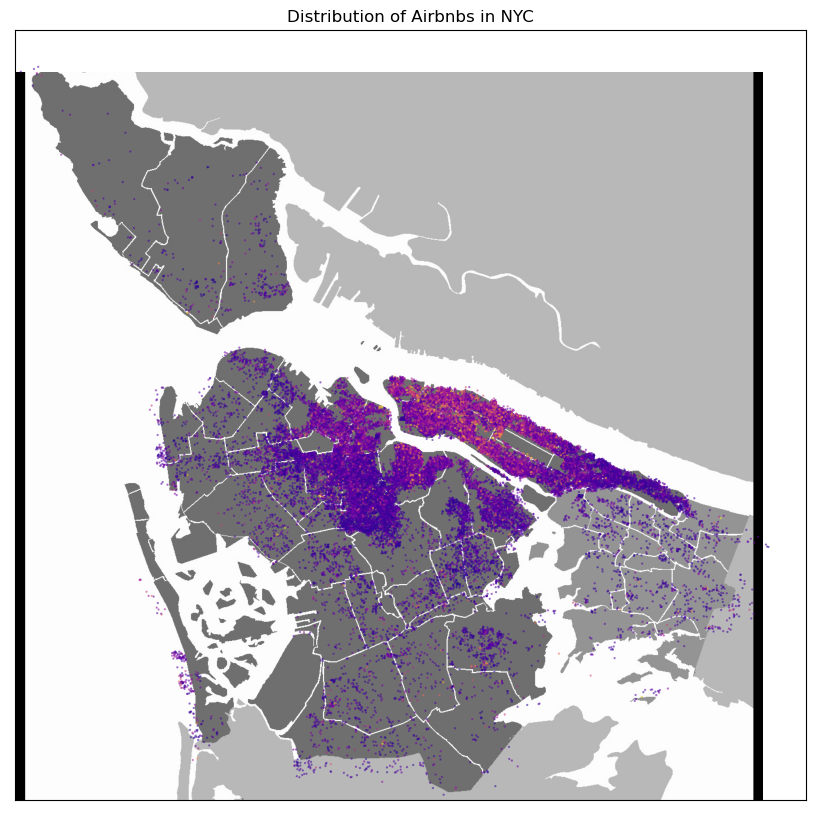

In [10]:
img = Image.open("data/New_York_City_.jpeg").rotate(270)
plt.figure()
fig, ax = plt.subplots(figsize=(20,10))
width,height = img.size
transp_lat =(eda_df["latitude"]-eda_df["latitude"].min())/(eda_df["latitude"].max()-eda_df["latitude"].min())*width
transp_long =(eda_df["longitude"]-eda_df["longitude"].min())/(eda_df["longitude"].max()-eda_df["longitude"].min())*height
ax.imshow(img);
colors = (eda_df["price"]-eda_df["price"].min())/(eda_df["price"].max()-eda_df["price"].min())
ax.scatter(transp_lat+10,transp_long-10, c=eda_df["price"],alpha=0.5,cmap="plasma",s=0.4);
ax = plt.gca()
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
ax.set_title("Distribution of Airbnbs in NYC");

### 2.3. Missing Values

last_review          10052
reviews_per_month    10052
host_name               21
name                    16
dtype: int64


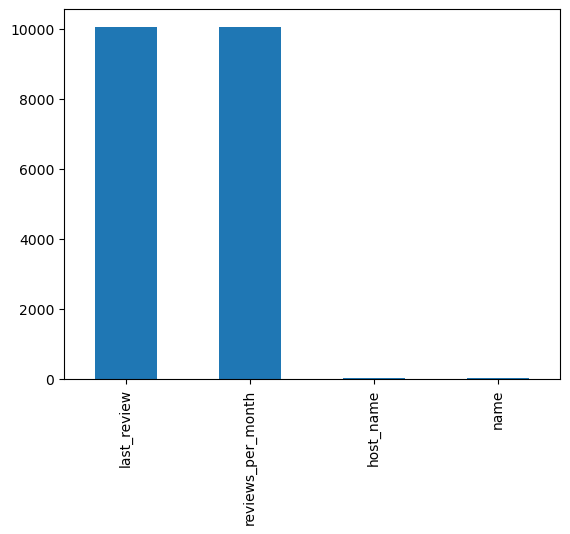

In [11]:
missing = pd.isna(df).sum().sort_values(ascending=False)
print(missing[missing>0])
missing[missing >0].plot.bar();

### 2.4 Inter-correlation of features

Plotting a correlation matrix of the quantitative features can help establish grounds for feature engineering or exclusion of variables. In this case Pearson's correlation coefficients are weak or non-existent, therefore we can leave them as-is.

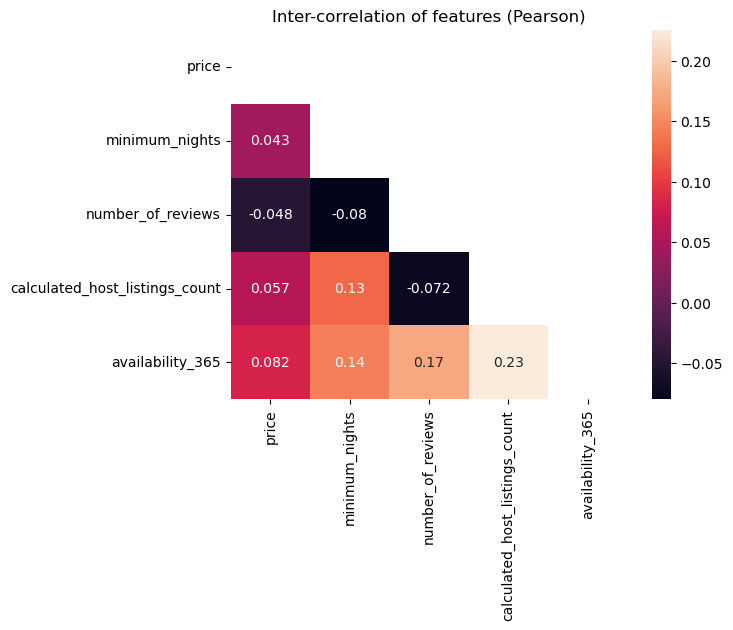

In [12]:
corr_mat = df[["price","minimum_nights","number_of_reviews","calculated_host_listings_count","availability_365"]].corr()

ax = plt.axes()
matrix = np.triu(corr_mat)
sns.heatmap(corr_mat,annot=True, ax = ax,mask=matrix)
ax.set_title('Inter-correlation of features (Pearson)')
plt.show()

Inter-correlation of variables is negligible (max: 0.082) (min: -0.08)

In [13]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']

<a id='data_ref'></a>

### 3. Refining the data

### 3.1. Basic preparations

**3.1. Removing Nan values from rows**

In [14]:

df = df.dropna()
df = df.drop(["name","host_id","host_name","latitude","longitude","last_review"],axis=1)

**3.2. Encoding categorical variables**

In [15]:
df = pd.get_dummies(df,columns=["room_type","neighbourhood_group","neighbourhood"],prefix="_")

**3.3 Splitting data to train and test set with label: price**

In [16]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

In [17]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()
train_labels = train_features.pop('price')
test_labels = test_features.pop('price')

**3.4. Adding keras.Normalization layer**

In [18]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

<a id='slr'></a>

## 4. Multiple Linear Regression

Multiple regression with 231 variables (due to one-hot-encoding). 

$ Y_i= \beta_0+\beta_1X_{1i}+\beta_2X_{2i}+...+\beta_{n}X_{ni}+u_i$

where:

$ Y_i $ : dependent variable

$ \beta_i $ : Y intercept

$ \beta_1 ... \beta_n $ : regression coefficients

$ X_{1i} ... X_{ni} $ : independent variables s.t. $ n = 231 $

$ u_i $ : error


In [19]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()
    

In [20]:
lr_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])
lr_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 231)              463       
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 232       
                                                                 
Total params: 695
Trainable params: 232
Non-trainable params: 463
_________________________________________________________________


In [21]:
lr_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

lr_history = lr_model.fit(
    train_features,
    train_labels,
    epochs=10,
    verbose=0,
    validation_split = 0.2)


In [22]:
y_hat = lr_model.predict(test_features)


243/243 [==============================] - 0s 684us/step


In [23]:
print(y_hat.flatten())
print(test_labels.to_numpy())
print(mean_absolute_error(test_labels.to_numpy(),y_hat.flatten()))

[103.530975  79.93999  157.43472  ...  94.34101  163.80759  162.5573  ]
[ 85  89 120 ... 135 150 235]
193.66869585370355


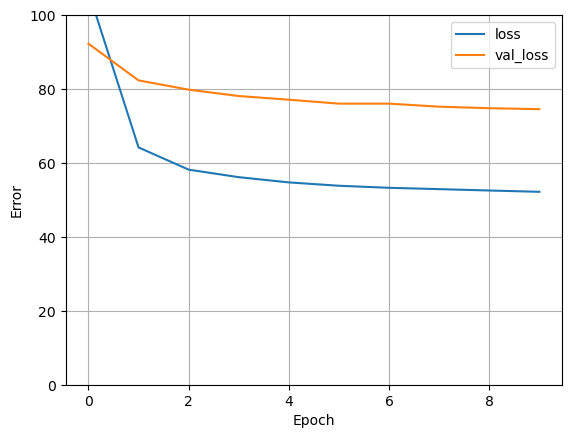

In [24]:

plot_loss(lr_history)

<a id='dnn'></a>

## 5. DNN Regression

Simple Deep Neural Network estimator in the form:

Normalizer Layer -> Hidden Layer 1 -> Hidden Layer 2 -> Output Layer

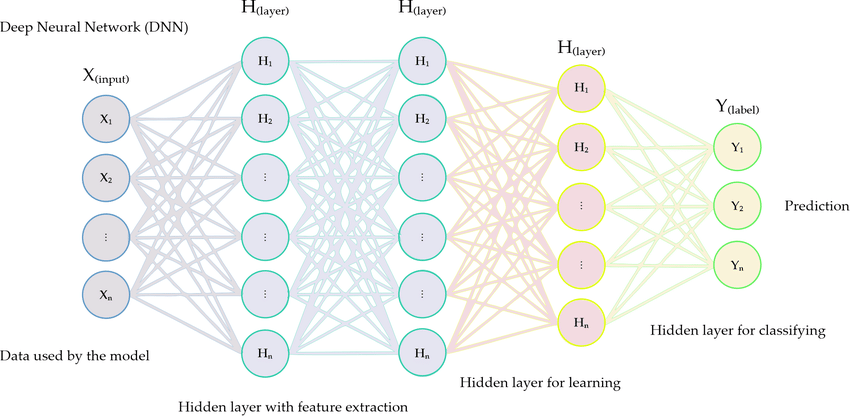

*Source: https://www.researchgate.net/publication/348688002/figure/fig1/AS:982812253487104@1611332109586/A-DNN-architecture-This-is-a-simple-example-of-how-a-DNN-may-be-built-Here-the-initial.ppm*

In [25]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(32, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [26]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 231)              463       
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 32)                7424      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8,976
Trainable params: 8,513
Non-trainable params: 463
_________________________________________________________________


In [27]:
dnn_history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=10)

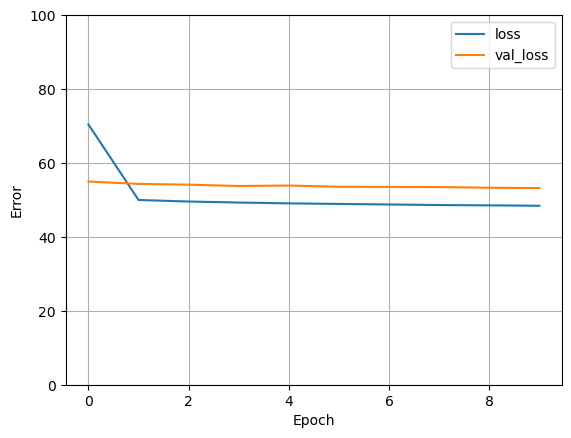

In [28]:
plot_loss(dnn_history)

<a id='xgb'></a>

## 6. XGBoost

Another, more advanced technique is XGBoost, which performed better than regression in previous Kaggle competitions so let's give it a shot. We will use Scikit-Learn's grid search method to tune hyperparams. 

In [29]:
from xgboost import XGBClassifier,XGBRegressor

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
le = LabelEncoder()
y_train = le.fit_transform(train_labels)
# parameters = {'booster':'gbtree', 'min_child_weight':5,
#               "max_depth":3,
#               "gamma":0}
xgb_model = XGBRegressor(booster="gbtree",min_child_weight=5,max_depth=3)
# clf =GridSearchCV(xgb_model,parameters)
xgb_history = xgb_model.fit(train_features, train_labels)

<a id='comparison'></a>

## 7. Model Comparison

In [31]:

y_pred_xgb = xgb_model.predict(test_features)
y_pred_slr = lr_model.predict(test_features)
y_pred_dnn = dnn_model.predict(test_features)


243/243 [==============================] - 0s 1ms/step


In [32]:
print(test_labels.to_numpy().shape)
print(y_pred_xgb.flatten().shape)

(7764,)
(7764,)


In [33]:
mae_dnn = mean_absolute_error(test_labels.to_numpy(),y_pred_dnn.flatten())
mae_xgb =mean_absolute_error(test_labels.to_numpy(),y_pred_xgb.flatten())
mae_slr = mean_absolute_error(test_labels.to_numpy(),y_pred_slr.flatten())

r2_dnn = r2_score(test_labels.to_numpy(),y_pred_dnn.flatten())
r2_xgb =r2_score(test_labels.to_numpy(),y_pred_xgb.flatten())
r2_slr = r2_score(test_labels.to_numpy(),y_pred_slr.flatten())

Text(0.5, 1.0, 'MAE scores for models')

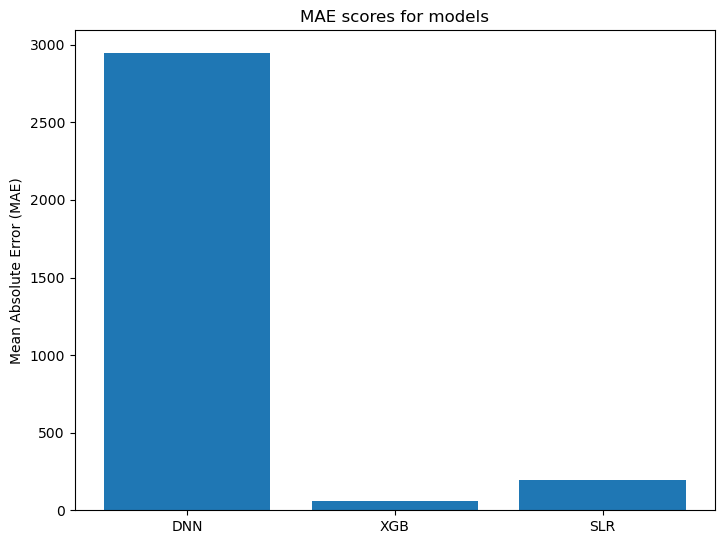

In [34]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(["DNN","XGB","SLR"],[mae_dnn,mae_xgb,mae_slr])
ax.set_ylabel("Mean Absolute Error (MAE)")
ax.set_title("MAE scores for models")

In [35]:
print("r2 score for XGB: {:.2f}".format(r2_xgb))
print("r2 score for DNN: {:.2f}".format(r2_dnn))
print("r2 score for SLR: {:.2f}".format(r2_slr))

r2 score for XGB: 0.08
r2 score for DNN: -1184029.51
r2 score for SLR: -2318.81
